In [1]:
#Based losely on: https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b

In [154]:
# Keras
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, GlobalAveragePooling1D
from keras.layers.embeddings import Embedding

from keras.optimizers import SGD

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils


import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE

import re
import string

import matplotlib
from matplotlib import pyplot as plt

In [14]:
colors_df=pd.read_csv('color_data_final.csv')
colors_df = colors_df.sample(frac=1).reset_index(drop=True)#shuffle dataframe - very important to learn all classes at the same time

In [30]:
np.max([len(nltk.word_tokenize(x)) for x in colors_df.context])

27

In [31]:
print("Dimensions of data: ", colors_df.shape)
maxlen = np.max([len(nltk.word_tokenize(x)) for x in colors_df.context])
print("Maximum context dimension: ", maxlen)
colors_df.head(3)

Dimensions of data:  (4235, 7)
Maximum context dimension:  27


,Unnamed: 0,name,context,code,red,green,blue
0,467,black,like saying red ninjas blue ninjas green ninja...,"(0, 0, 0)",0,0,0
1,3035,yellow,varied gathering products busy far sunlit pano...,"(255, 255, 0)",255,255,0
2,695,blue,real difference natural supernatural flew sky ...,"(0, 0, 255)",0,0,255


In [116]:
vocabulary_size = 20000
t = Tokenizer(num_words= vocabulary_size)
t.fit_on_texts(colors_df.context)
sequences = t.texts_to_sequences(colors_df.context)
#print(sequences)
data = pad_sequences(sequences, maxlen=maxlen)

dataY = np.column_stack([colors_df.red/255, colors_df.green/255, colors_df.blue/255])

In [111]:
def create_conv_model():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=maxlen))
    #model.add(Dropout(0.1))
    model.add(Conv1D(64, 2))# activation='relu'))
    model.add(Conv1D(64, 3))# activation='relu'))
    model.add(Conv1D(64, 2))# activation='relu'))
    #model.add(MaxPooling1D(pool_size=2)) # sliding a kernel of 4 accross the input (for 2D is (4,4)) etc.
    #model.add(Conv1D(512, 3, activation='relu'))
    #model.add(GlobalAveragePooling1D())
    #model.add(LSTM(256, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
    #model.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))# return_sequences=True,
    model.add(LSTM(100, dropout=0.1))#, recurrent_dropout=0.2))
    #model.add(Dense(128))#, activation='relu'))# sigmoid#relu
    model.add(Dense(3, activation='sigmoid'))#softmax
    
    adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=adam,    metrics=['accuracy'])
    
    #from https://keras.io/callbacks/
    early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=0)#, restore_best_weights=False)# monitor='val_loss'
    checkpointer = ModelCheckpoint('model_best_conv_{val_acc:.2f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True)#weights.{epoch:02d}-{val_loss:.2f}.hdf5 #monitor='val_loss'#{val_loss:.2f}
    model.summary()
    return model, early_stopping, checkpointer

In [112]:
model, early_stopping, checkpointer = create_conv_model()
#model_conv.fit(data, np.array(labels), validation_split=0.4, epochs = 3)
#model.fit(data, dataY, validation_split=0.2, epochs = 50)


history = model.fit(data, dataY,
                    epochs=120,
                    batch_size=32,
                    validation_split=0.1,
                   shuffle=True, callbacks=[early_stopping, checkpointer])
model.save('model_conv_final.hdf5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 27, 100)           2000000   
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 26, 64)            12864     
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 24, 64)            12352     
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 23, 64)            8256      
_________________________________________________________________
lstm_83 (LSTM)               (None, 100)               66000     
_________________________________________________________________
dense_69 (Dense)             (None, 3)                 303       
Total params: 2,099,775
Trainable params: 2,099,775
Non-trainable params: 0
_________________________________________________________________



Epoch 00035: val_acc did not improve
Epoch 36/120
3811/3811 [==============================] - 13s 3ms/step - loss: 0.1249 - acc: 0.8658 - val_loss: 1.0777 - val_acc: 0.6305

Epoch 00036: val_acc did not improve
Epoch 37/120
3811/3811 [==============================] - 13s 3ms/step - loss: 0.1235 - acc: 0.8674 - val_loss: 1.0809 - val_acc: 0.6344

Epoch 00037: val_acc did not improve
Epoch 38/120
3811/3811 [==============================] - 13s 3ms/step - loss: 0.1221 - acc: 0.8659 - val_loss: 1.0885 - val_acc: 0.6321

Epoch 00038: val_acc did not improve
Epoch 39/120
3811/3811 [==============================] - 13s 3ms/step - loss: 0.1204 - acc: 0.8673 - val_loss: 1.0839 - val_acc: 0.6329

Epoch 00039: val_acc did not improve
Epoch 40/120
3811/3811 [==============================] - 13s 3ms/step - loss: 0.1194 - acc: 0.8683 - val_loss: 1.0983 - val_acc: 0.6281

Epoch 00040: val_acc did not improve
Epoch 41/120
3811/3811 [==============================] - 13s 3ms/step - loss: 0.1181 -

In [44]:
def get_model1():
    model = Sequential()
    model.add(Embedding(20000, 100, input_length=maxlen))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='sigmoid'))
    
    adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=adam,    metrics=['accuracy'])
    
    #from https://keras.io/callbacks/
    early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=7, verbose=0)#, restore_best_weights=False)# monitor='val_loss'
    checkpointer = ModelCheckpoint('model_best_word_{val_acc:.2f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True)#weights.{epoch:02d}-{val_loss:.2f}.hdf5 #monitor='val_loss'#{val_loss:.2f}
    model.summary()
    return model, early_stopping, checkpointer
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
model, early_stopping, checkpointer = get_model1()
#model_conv.fit(data, np.array(labels), validation_split=0.4, epochs = 3)
#model.fit(data, dataY, validation_split=0.2, epochs = 50)


history = model.fit(data, dataY,
                    epochs=120,
                    batch_size=32,
                    validation_split=0.1,
                   shuffle=True, callbacks=[early_stopping, checkpointer])
model.save('model_word_final.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 27, 100)           2000000   
_________________________________________________________________
lstm_24 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 303       
Total params: 2,080,703
Trainable params: 2,080,703
Non-trainable params: 0
_________________________________________________________________
Train on 3811 samples, validate on 424 samples
Epoch 1/120
3811/3811 [==============================] - 16s 4ms/step - loss: 0.6886 - acc: 0.4930 - val_loss: 0.6869 - val_acc: 0.4733

Epoch 00001: val_acc improved from -inf to 0.47327, saving model to model_best_word_0.47.hdf5
Epoch 2/120
3811/3811 [==============================] - 14s 4ms/step - loss: 0.6827 - acc: 0.4932 - val_loss: 0.6853 

Epoch 35/120
3811/3811 [==============================] - 14s 4ms/step - loss: 0.2055 - acc: 0.8484 - val_loss: 0.8900 - val_acc: 0.6399

Epoch 00035: val_acc improved from 0.63758 to 0.63994, saving model to model_best_word_0.64.hdf5
Epoch 36/120
3811/3811 [==============================] - 14s 4ms/step - loss: 0.1984 - acc: 0.8515 - val_loss: 0.9364 - val_acc: 0.6336

Epoch 00036: val_acc did not improve
Epoch 37/120
3811/3811 [==============================] - 14s 4ms/step - loss: 0.1966 - acc: 0.8527 - val_loss: 0.8866 - val_acc: 0.6392

Epoch 00037: val_acc did not improve
Epoch 38/120
3811/3811 [==============================] - 14s 4ms/step - loss: 0.1931 - acc: 0.8527 - val_loss: 0.9499 - val_acc: 0.6329

Epoch 00038: val_acc did not improve
Epoch 39/120
3811/3811 [==============================] - 14s 4ms/step - loss: 0.1877 - acc: 0.8555 - val_loss: 0.9395 - val_acc: 0.6384

Epoch 00039: val_acc did not improve
Epoch 40/120
3811/3811 [==============================] - 14s 4ms

In [119]:
filename = 'model_conv_final.hdf5'
model.load_weights(filename)

In [120]:
word_list = []
for word, i in t.word_index.items():
    word_list.append(word)

In [121]:
## Get weights
conv_embds = model.layers[0].get_weights()[0]
## Plotting function
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)
## Visualize words in two dimensions 
conv_tsne_embds = TSNE(n_components=2).fit_transform(conv_embds)
plot_words(conv_tsne_embds, 0, 2000, 1)

In [131]:
def remove_stop_punct(text):
    tokenized = [w.lower() for w in text if not re.fullmatch('[' + string.punctuation + ']+', w)]
    #print(tokenized)
    
    processed_data=[w for w in tokenized if w not in stopwords.words("english")]
    
    output = [re.sub(r'\d+', '', w) for w in processed_data] #remove numbers
    #'hello467'.translate(None, '0123456789')
    output = [word.lower() for word in output if word.isalpha()]
    output = [word.encode('ascii',errors='ignore').decode() for word in output]
    output = [word for word in output if len(word)!=0]
    return output
    #return ''.join(tokenized)

In [149]:
#text no longer than the length=171
def get_color_from_text(text):
    text = remove_stop_punct(text)
    #t =Tokenizer(char_level=True)
    #t.fit_on_texts(df2.noun)
    #t.fit_on_texts(text)
    tokenized = t.texts_to_sequences([text])
    pad = keras.preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    #one_hot = np_utils.to_categorical(pad, num_classes=num_classes)
    #pred = (model.predict(np.array(one_hot))[0])#*255
    pred = (model.predict(np.array(pad))[0])#*255
    #pred = [float(x) for x in pred ]
    print("Colors predicted: ", pred)
    
    return pred

In [150]:
one_hot_names = np_utils.to_categorical(data)
num_classes = one_hot_names.shape[-1]
num_classes

11600

In [151]:
from nltk import tokenize
def get_chunks(text):
    sentences = tokenize.sent_tokenize(text)
    colors = [get_color_from_text(s) for s in sentences]
    return colors

In [144]:
import mpl_toolkits.axes_grid1 as axes_grid1
#np.random.seed(1)

#data = np.random.randn(10, 10)

def plot_all_text(data):
    
    fig = plt.figure(figsize=(15,5))
    grid = axes_grid1.AxesGrid(
        fig, 111, nrows_ncols=(1, 1), axes_pad = 0.5, cbar_location = "right",
        cbar_mode="each", cbar_size="15%", cbar_pad="5%",)

    #im0 = grid[0].imshow(data, cmap='gray', interpolation='nearest')
    #im0 = grid[0].imshow(data, cmap='gray', interpolation='nearest')
    #grid.cbar_axes[0].colorbar(im0)

    im1 = grid[0].imshow(data, cmap='jet', interpolation='nearest')
    grid.cbar_axes[0].colorbar(im1)
    plt.savefig('/tmp/test.png', bbox_inches='tight', pad_inches=0.0, dpi=200,)

In [171]:
def text_to_colors(text, n):
    sents = nltk.sent_tokenize(text)   
    tokens = [nltk.tokenize.word_tokenize(s) for s in sents]
    #print(tokens)
    sents_nopunct = [' '.join(remove_stop_punct(s)) for s in tokens] 
    #print(sents_nopunct)
    temp_text = '. '.join(sents_nopunct[:n])
    chunks = get_chunks(temp_text)
    plot_all_text(chunks)
    

Colors predicted:  [0.99895585 0.99928397 0.99584085]
Colors predicted:  [0.98775    0.99914944 0.5654308 ]
Colors predicted:  [0.9601488  0.98614687 0.17508477]


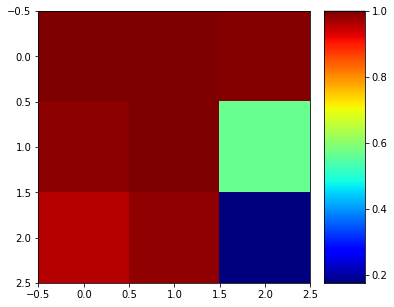

In [172]:
text_to_colors('moby dick herman melville. etymology. supplied late consumptive usher grammar school.', 15)

In [145]:
from nltk.book import *
moby = nltk.Text(gutenberg.sents('melville-moby_dick.txt'))
#moby.collocations()
moby.tokens[0]

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', '1851', ']']

In [146]:
moby_sents = [' '.join(remove_stop_punct(s)) for s in moby.tokens]

In [147]:
moby_text ='. '.join(moby_sents[:15])
moby_text

'moby dick herman melville. etymology. supplied late consumptive usher grammar school. pale usher threadbare coat heart body brain see. ever dusting old lexicons grammars queer handkerchief mockingly embellished gay flags known nations world. loved dust old grammars somehow mildly reminded mortality. take hand school others teach name whale fish called tongue leaving ignorance letter h almost alone maketh signification word deliver true. hackluyt. whale. sw dan. hval. animal named roundness rolling dan. hvalt arched vaulted. webster dictionary. whale'

In [152]:
chunks = get_chunks(moby_text)

Colors predicted:  [0.99895585 0.99928397 0.99584085]
Colors predicted:  [0.98775    0.99914944 0.5654308 ]
Colors predicted:  [0.9601488  0.98614687 0.17508477]
Colors predicted:  [0.00578618 0.00408316 0.9883885 ]
Colors predicted:  [0.4144859  0.24948993 0.5217993 ]
Colors predicted:  [0.99647886 0.9829465  0.90795255]
Colors predicted:  [0.7994658  0.86355823 0.7080333 ]
Colors predicted:  [0.62526363 0.9993994  0.44490486]
Colors predicted:  [0.03516858 0.99676126 0.01794564]
Colors predicted:  [0.01419517 0.00685475 0.00409163]
Colors predicted:  [0.44204655 0.9660872  0.36080313]
Colors predicted:  [0.99805826 0.9825225  0.9967596 ]
Colors predicted:  [0.995656  0.9992599 0.8207853]
Colors predicted:  [6.0177317e-05 8.7407185e-03 1.3048721e-02]
Colors predicted:  [0.03516858 0.99676126 0.01794564]


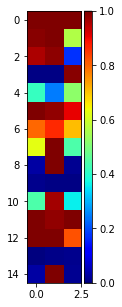

In [155]:
plot_all_text(chunks)

In [161]:
#plot_all_text(get_chunks('green grass frog'))

Colors predicted:  [0.99895585 0.99928397 0.99584085]
Colors predicted:  [0.98775    0.99914944 0.5654308 ]
Colors predicted:  [0.9601488  0.98614687 0.17508477]
Colors predicted:  [0.00578618 0.00408316 0.9883885 ]
Colors predicted:  [0.4144859  0.24948993 0.5217993 ]
Colors predicted:  [0.99647886 0.9829465  0.90795255]
Colors predicted:  [0.7994658  0.86355823 0.7080333 ]
Colors predicted:  [0.62526363 0.9993994  0.44490486]
Colors predicted:  [0.03516858 0.99676126 0.01794564]
Colors predicted:  [0.01419517 0.00685475 0.00409163]
Colors predicted:  [0.44204655 0.9660872  0.36080313]
Colors predicted:  [0.99805826 0.9825225  0.9967596 ]
Colors predicted:  [0.995656  0.9992599 0.8207853]
Colors predicted:  [6.0177317e-05 8.7407185e-03 1.3048721e-02]
Colors predicted:  [0.03516858 0.99676126 0.01794564]


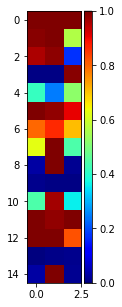

In [177]:
text_to_colors(moby_text, 15)

In [178]:
songs = pd.read_csv('songdata.csv')

In [180]:
songs = songs.sample(frac=1).reset_index(drop=True)#shuffle dataframe

In [182]:
songs.head(20)

,artist,song,link,text
0,Hanson,Smile,/h/hanson/smile_20064284.html,Well this feeling that you're feeling \nIs so...
1,J Cole,Wet Dreamz,/j/j+cole/wet+dreamz_21091270.html,"[Intro] \nCole \nCole, world \nYeah \nLet ..."
2,Yoko Ono,Mrs. Lennon,/y/yoko+ono/mrs+lennon_10195979.html,"Mrs. Lennon, o' Mrs. Lennon, \nChecking the s..."
3,Phish,Tweezer,/p/phish/tweezer_20108401.html,Won't you step into the freezer \nSeize her w...
4,Ramones,Teenage Labotomy,/r/ramones/teenage+labotomy_20322749.html,Lobotomy! Lobotomy! Lobotomy! Lobotomy! \n \...
5,Hollies,Mighty Quinn,/h/hollies/mighty+quinn_20065692.html,"(Dylan) \nCome all without, come all within ..."
6,Rammstein,Shtil,/r/rammstein/shtil_20619493.html,Shtil'- veter molchit \nUpal beloj chajkoj na...
7,David Allan Coe,Would You Lay With Me,/d/david+allan+coe/would+you+lay+with+me_20585...,By David Allan Coe \n \nWould you lay with m...
8,Christy Moore,Beeswing,/c/christy+moore/beeswing_20834521.html,I was 18 when I came to town \nThey called it...
9,Johnny Cash,Blue Christmas,/j/johnny+cash/blue+christmas_20154288.html,I'll have a blue blue Christmas) \nI'll have ...


In [192]:
song1 = songs.text[0].replace ('\n', '.')
song2 = songs.text[10].replace ('\n', '.')

Colors predicted:  [0.64335626 0.23503706 0.03207611]
Colors predicted:  [0.99939966 0.99974674 0.98188674]
Colors predicted:  [0.9997979  0.99939036 0.99881005]
Colors predicted:  [0.9908652  0.9693475  0.81667763]
Colors predicted:  [0.99958974 0.99803907 0.9945695 ]
Colors predicted:  [0.99939966 0.99974674 0.98188674]
Colors predicted:  [0.9908652  0.9693475  0.81667763]
Colors predicted:  [0.03645789 0.14696671 0.6127545 ]
Colors predicted:  [0.999059   0.99898213 0.98370725]
Colors predicted:  [0.9694732 0.9996712 0.555242 ]
Colors predicted:  [0.01172246 0.6551819  0.0037338 ]
Colors predicted:  [0.10051474 0.99711907 0.05374417]
Colors predicted:  [0.11477721 0.9370579  0.19667378]
Colors predicted:  [0.4258976  0.34025165 0.28897366]
Colors predicted:  [0.00902881 0.17149445 0.00185988]
Colors predicted:  [0.9772981  0.9455903  0.16048768]
Colors predicted:  [0.4258976  0.34025165 0.28897366]
Colors predicted:  [0.34102923 0.9947189  0.01680136]
Colors predicted:  [0.00431402 

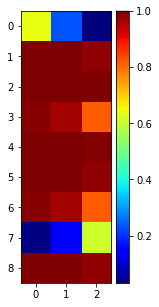

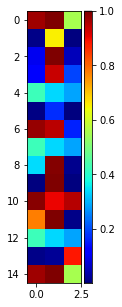

In [193]:
#plt.figure(figsize=(2,2))
text_to_colors(song1, 15)
text_to_colors(song2, 15)
#colors=[[pred]]
#im = plt.imshow(colors, interpolation='nearest', aspect='auto')
#plt.colorbar(im, orientation='vertical')
#plt.show()